In these Notebook we are going to summarize the Messages for getting filled with context window

Importing Required Libraries

In [37]:
from typing import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import AIMessage,SystemMessage,HumanMessage,AnyMessage,RemoveMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from dotenv import load_dotenv
from langchain_core.runnables import RunnableConfig

load_dotenv()

True

Creating the State

In [38]:
class StateSchema(MessagesState):
    summary:str

LLM Model Instance

In [39]:
llm_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
)

Creating the Nodes

In [40]:
def call_model(state: StateSchema) -> StateSchema:
    summary = state.get("summary", "")
    print(summary)
    system_message_model = SystemMessage(
        "you are helpful assistant. Replies to user queries")
    if summary:
        system_message = [
            system_message_model,
            SystemMessage(
                f"Here is the summary of the conversation earlier: {summary}")
        ]
        system_message.extend(state["messages"])
        messages: list[AnyMessage] = system_message
    else:
        messages: list[AnyMessage] = state["messages"]
    response = llm_model.invoke(messages)
    return {
        "messages": response
    }

In [41]:
def summarize_converstation(state: StateSchema) -> StateSchema:
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create the summary of the converstation above: "
    messages = state["messages"]+[HumanMessage(summary_message)]
    response = llm_model.invoke(messages)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

Conditional Edge to determine when to call the `summarize_converstation`node

In [42]:
from typing import Literal


def should_continue(state:StateSchema)->Literal["summarize_converstation","__end__"]:
    messages=state.get("messages",[])
    if len(messages) > 4:
        return "summarize_converstation"
    return "__end__"

Creating the Graph

In [43]:
from langgraph.checkpoint.memory import InMemorySaver

graph = StateGraph(StateSchema)
graph.add_node("call_model",call_model)
graph.add_node(summarize_converstation)

graph.add_edge(START,"call_model")
graph.add_conditional_edges("call_model",should_continue)
graph.add_edge("summarize_converstation",END)

memory = InMemorySaver()
compile_graph=graph.compile(checkpointer=memory)

Displaying the graph

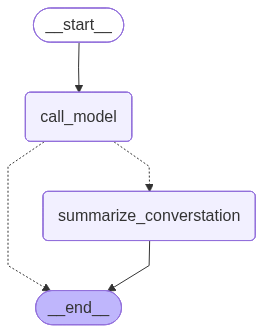

In [44]:
from IPython.display import display,Image

display(Image(compile_graph.get_graph().draw_mermaid_png()))

Invoking the Graph

In [45]:
config: RunnableConfig = {
    "configurable": {
        'thread_id':1
    }
}

In [46]:
input_message = HumanMessage(content="hi! I'm Lance")
messages = compile_graph.invoke({"messages":[input_message]},config)
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you.

I'm an AI assistant, and I'm here to help with whatever you need. What can I do for you today?


In [47]:
input_message = HumanMessage("what you are able to do")
messages = await compile_graph.ainvoke({"messages":[input_message]},config)
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you.

I'm an AI assistant, and I'm here to help with whatever you need. What can I do for you today?
================================ Human Message =================================

what you are able to do
================================== Ai Message ==================================

That's a great question, Lance! As an AI assistant, I can do quite a lot to help you out. Here's a breakdown of my main capabilities:

1.  **Answering Questions & Providing Information:**
    *   I can answer questions on a vast range of topics, from science and history to pop culture and current events (up to my last training update).
    *   I can explain complex concepts in simpler terms.
    *   I can provide definitions, facts, and figures.

2.  **Generating Various Types of Text:**
    *   

In [48]:
input_message = HumanMessage("so you are coder too")
messages = await compile_graph.ainvoke({"messages":[input_message]},config)
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

so you are coder too
================================== Ai Message ==================================

That's a great follow-up question, Lance, and it helps clarify things!

I can **generate code and help with coding tasks**, but I wouldn't say I *am* a "coder" in the human sense.

Here's the distinction:

*   **What I can do (like a coding assistant):**
    *   **Generate code snippets:** I can write code in various languages (Python, JavaScript, C++, Java, Ruby, SQL, etc.) based on your descriptions or requirements.
    *   **Explain coding concepts:** I can break down algorithms, data structures, design patterns, and programming paradigms.
    *   **Debug simple issues:** If you show me an error message or a piece of code that's not working, I can often suggest potential fixes or point out common mistakes.
    *   **Refactor and optimize:** I can suggest ways to improve existing code for readability,

Getting the State from the graph

In [50]:
compile_graph.get_state(config).values

{'messages': [HumanMessage(content='so you are coder too', additional_kwargs={}, response_metadata={}, id='284a7061-680e-423e-b82f-962ff7051e75'),
  AIMessage(content='That\'s a great follow-up question, Lance, and it helps clarify things!\n\nI can **generate code and help with coding tasks**, but I wouldn\'t say I *am* a "coder" in the human sense.\n\nHere\'s the distinction:\n\n*   **What I can do (like a coding assistant):**\n    *   **Generate code snippets:** I can write code in various languages (Python, JavaScript, C++, Java, Ruby, SQL, etc.) based on your descriptions or requirements.\n    *   **Explain coding concepts:** I can break down algorithms, data structures, design patterns, and programming paradigms.\n    *   **Debug simple issues:** If you show me an error message or a piece of code that\'s not working, I can often suggest potential fixes or point out common mistakes.\n    *   **Refactor and optimize:** I can suggest ways to improve existing code for readability, eff